# COMP5318 - Machine Learning and Data Mining: Assignment 1
<div style="text-align: right"> Due: Tuesday 8 Oct 2019 5:00PM </div>

# Summary
The goal of this assignment is to build a classifier to classify some grayscale images of the size 28x28 into a set of categories. The dimension of the original data is large, so you need to be smart on which method you gonna use and perhaps perform a pre-processing step to reduce the amount of computation. Part of your marks will be a function of the performance of your classifier on the test set.

## Dataset description
The dataset can be downloaded from Canvas. The dataset consists of a training set of 30,000 examples and a test set of 5,000 examples. They belong to 10 different categories. The validation set is not provided, but you can randomly pick a subset of the training set for validation. The labels of the first 2,000 test examples are given, you will analyse the performance of your proposed method by exploiting the 2,000 test examples. It is NOT allowed to use any examples from the test set for training; or it will be considered as cheating. The rest 3,000 labels of the test set are reserved for marking purpose. <br />
Here are examples illustrating sample of the dataset (each class takes one row):

<img src="Dataset_image.jpg" alt="DataSet" title="DataSet" width="450" height="300" />

There are 10 classes in total:<br />
0 T-shirt/Top<br />
1 Trouser<br />
2 Pullover<br />
3 Dress<br />
4 Coat<br />
5 Sandal<br />
6 Shirt<br />
7 Sneaker<br />
8 Bag<br />
9 Ankle boot <br />

### How to load the data
There is a data folder with 4 main files (which can be downloaded from Canvas):
    1. images_training.h5
    2. labels_training.h5
    3. images_testing.h5
    4. labels_testing_2000.h5

To read the hdf5 file and load the data into a numpy array, assuming the **training data files are in the ./data/train** and **testing data file are in ./data/test**. <br /> Use the following code:

Then data would be a numpy array of the shape (30000, 784), and
label would be a numpy array of the shape (30000, ).
The file images_testing.h5 can be loaded in a similar way.

# Loading the libraries

In [40]:
import h5py
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import operator

# Reading Fashion MNIST data

In [41]:
print(os.listdir("./data/train"))

with h5py.File('./data/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./data/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])


print("Shape of train data and train label:",data_train.shape,label_train.shape)

print(os.listdir("./Input"))
with h5py.File('./Input/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./Input/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])

print("Shape of test data and test label:",data_test.shape,label_test.shape)

['images_training.h5', 'labels_training.h5']
Shape of train data and train label: (30000, 784) (30000,)
['images_testing.h5', 'labels_testing_2000.h5']
Shape of test data and test label: (10000, 784) (2000,)


Showing a sample data. The first example belongs to class 0: T-Shirt/Top

# Reshaping data

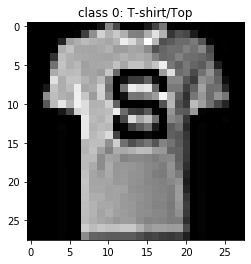

In [42]:
data_train_before_reshape = data_train
data_train = data_train.reshape((data_train.shape[0], 28, 28))
plt.imshow(data_train[4], cmap=plt.get_cmap('gray'))
plt.title("class " + str(label_train[4]) + ": T-shirt/Top" )
plt.show()

# Running SVD

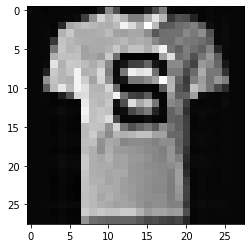

In [43]:
#using rank, we decomposed the matrices usind svd
train_svd = data_train.copy()
i = 0
while i<30000: 
    y1 = np.linalg.matrix_rank(data_train[i])
    #print("Rank",y[i])
    U, s, Vt = np.linalg.svd(data_train[i], full_matrices=False) 
    S = np.diag(s)
    S1 = np.round(S,2)
    S2 = S1[:y1,:y1]
    U1 = np.round(U,2)
    U2 = U1[:,0:y1]
    Vt1 = np.round(Vt,2)
    Vt2 = Vt1[0:y1,:]
    train_svd[i] = U2.dot(S2.dot(Vt2))
    i = i + 1
   
plt.imshow(train_svd[4], cmap=plt.get_cmap('gray'))

# Logistic regression functions

In [44]:
#function to split the training data 
def train_test_split(dataset, split=0.60):
    train_size = int(split * dataset.shape[0])
    return dataset[:train_size,:], dataset[train_size:,:]

#softmax function
def softmax(Z):
    e_Z = np.exp(Z)
    A = e_Z / e_Z.sum(axis = 1, keepdims = True)
    return A

#gradient descent
def softmax_grad(X, y, W):
    A = softmax(X.dot(W))    
    id0 = range(X.shape[0])  
    A[id0, y] -= 1          
    return X.T.dot(A)/X.shape[0]

#calculate the cost
def softmax_loss(X, y, W):
    A = softmax(X.dot(W))
    id0 = range(X.shape[0])
    return -np.mean(np.log(A[id0, y]))


def softmax_fit(X, y, W, lr = 0.01, nepoches = 100, tol = 1e-5, batch_size = 10):
    W_old = W.copy()
    ep = 0 
    loss_hist = [softmax_loss(X, y, W)] 
    N = X.shape[0]
    nbatches = int(np.ceil(float(N)/batch_size)) #number of batches is inversely proprtional to the batch size
    while ep < nepoches: 
        ep += 1 
        mix_ids = np.random.permutation(N) # randomizing the data. similar to bootstrapping
        for i in range(nbatches):
            # get the i-th batch
            batch_ids = mix_ids[batch_size*i:min(batch_size*(i+1), N)] 
            X_batch, y_batch = X[batch_ids], y[batch_ids]
            W -= lr*softmax_grad(X_batch, y_batch, W) # update gradient descent
        loss_hist.append(softmax_loss(X, y, W))
        if np.linalg.norm(W - W_old)/W.size < tol:    #if the change in the weights is less than the threshold, we stop with the computation
            break 
        W_old = W.copy()
    return W, loss_hist 

# predicting the class
def pred(W, X):
    A = softmax(X.dot(W))
    return np.argmax(A, axis = 1) #returning the class with the maximum probability

#percentage of correct classifications
def accuracy(y_pre,y):
    count = y_pre == y
    accuracy = count.sum()/len(count)
    return accuracy

# Computing the accuracy using logistic by splitting into validation set (40%-60%)

In [45]:
trainingSet = np.append(data_train_before_reshape,label_train[:,np.newaxis],axis=1) 
train, test = train_test_split(trainingSet,0.4)
W_init = 0.1*np.random.randn(data_train_before_reshape.shape[1], 10) #initialising the weights for the 10 classes (and 784 pixels)
data1 = train[:,:784]
lab1 = train[:,784]
lab1 = lab1.astype('int32')
data2 = test[:,:784]
lab2 = test[:,784]
start_time = time.time()
W, loss_hist = softmax_fit(data1, lab1, W_init, batch_size = 100, nepoches = 100, lr = 0.01)
y_pre = pred(W,data2)
elapsed_time = time.time()-start_time
accuracy_40 = (accuracy(y_pre,lab2)*100.0)
elapsed_40 = (elapsed_time)
print("Accuracy on validation set (40-60): {}%".format(accuracy_40))
print("Run Time on validation set (40-60):",round((elapsed_40/60.0),2),"Minutes")

Accuracy on validation set (40-60): 78.81666666666666%
Run Time on validation set (40-60): 0.04 Minutes


# Computing the accuracy using logistic by splitting into validation set (60%-40%)

In [46]:
trainingSet = np.append(data_train_before_reshape,label_train[:,np.newaxis],axis=1) 
train, test = train_test_split(trainingSet,0.6)
W_init = 0.1*np.random.randn(data_train_before_reshape.shape[1], 10) #initialising the weights for the 10 classes (and 784 pixels)
data1 = train[:,:784]
lab1 = train[:,784]
lab1 = lab1.astype('int32')
data2 = test[:,:784]
lab2 = test[:,784]
start_time = time.time()
W, loss_hist = softmax_fit(data1, lab1, W_init, batch_size = 100, nepoches = 100, lr = 0.01)
y_pre = pred(W,data2)
elapsed_time = time.time()-start_time
accuracy_60 = (accuracy(y_pre,lab2)*100.0)
elapsed_60 = (elapsed_time)
print("Accuracy on validation set (60-40): {}%".format(accuracy_60))
print("Run Time on validation set (60-40):",round((elapsed_60/60.0),2),"Minutes")

Accuracy on validation set (60-40): 80.375%
Run Time on validation set (60-40): 0.08 Minutes


# Computing the accuracy using logistic by splitting into validation set (70%-30%)

In [47]:
trainingSet = np.append(data_train_before_reshape,label_train[:,np.newaxis],axis=1) 
train, test = train_test_split(trainingSet,0.7)
W_init = 0.1*np.random.randn(data_train_before_reshape.shape[1], 10) #initialising the weights for the 10 classes (and 784 pixels)
data1 = train[:,:784]
lab1 = train[:,784]
lab1 = lab1.astype('int32')
data2 = test[:,:784]
lab2 = test[:,784]
start_time = time.time()
W, loss_hist = softmax_fit(data1, lab1, W_init, batch_size = 100, nepoches = 100, lr = 0.01)
y_pre = pred(W,data2)
elapsed_time = time.time()-start_time
accuracy_70 = (accuracy(y_pre,lab2)*100.0)
elapsed_70 = (elapsed_time)
print("Accuracy on validation set (70-30): {}%".format(accuracy_70))
print("Run Time on validation set (70-30):",round((elapsed_70/60.0),2),"Minutes")

Accuracy on validation set (70-30): 81.13333333333334%
Run Time on validation set (70-30): 0.1 Minutes


# Calling logistic regression on test data

In [48]:
W_init = 0.1*np.random.randn(data_train_before_reshape.shape[1], 10) #initialising the weights for the 10 classes (and 784 pixels)
start_time = time.time()
W, loss_hist = softmax_fit(data_train_before_reshape, label_train, W_init, batch_size = 100, nepoches = 100, lr = 0.05) 
y_pre = pred(W,data_test) #predicting the results
elapsed_time = time.time()-start_time
accuracy = accuracy(y_pre[:2000],label_test)*100.0
print("Accuracy on test set: {}%".format(accuracy))
print("Run Time on test set:",round((elapsed_time)/60.0,2),"Minutes")

Accuracy on test set: 83.5%
Run Time on test set: 0.48 Minutes


# Evaluating logistic regression

In [50]:
y_actu = pd.Series(label_test, name='Actual')
y_pred = pd.Series(y_pre[:2000], name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_conf_norm = df_confusion / df_confusion.sum(axis=1)
plt.matshow(df_confusion, cmap=cmap) # imshow
plt.colorbar()
tick_marks = np.arange(len(df_confusion.columns))
plt.ylabel(df_confusion.index.name)
plt.xlabel(df_confusion.columns.name)


NameError: name 'cmap' is not defined

In [51]:
j = 0
precision = []
recall = []
f1 = []
true_pos = [] #true positive
false_pos = [] #false positive
roc_truepositive = [] #for ROC curve
roc_falsepositive = []
while j <= 9:
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for i in range(0,2000):
        if(y_pred[i] == j and label_test[i] == j):
            TP += 1
        elif (y_pred[i] == j and label_test[i] != j):
            FP += 1 
        elif (y_pred[i] != j and label_test[i] == j):
            FN += 1
        else:
            TN += 1
    p = TP/(TP+FP)
    r = TP/(TP+FN)
    fr = FP/(2000-(TP+FP))
    f = (2*p*r)/(p+r)
    roc_truepositive.append(p)
    roc_falsepositive.append(fr)
    precision.append((j,round(p,2)))
    recall.append((j,round(r,2)))
    f1.append((j,round(f,2)))
    j = j + 1
    
print(precision)
print(recall)
print(f1)

[(0, 0.83), (1, 0.96), (2, 0.64), (3, 0.89), (4, 0.73), (5, 0.93), (6, 0.63), (7, 0.88), (8, 0.95), (9, 0.94)]
[(0, 0.77), (1, 0.99), (2, 0.82), (3, 0.81), (4, 0.71), (5, 0.89), (6, 0.6), (7, 0.93), (8, 0.95), (9, 0.93)]
[(0, 0.8), (1, 0.97), (2, 0.72), (3, 0.85), (4, 0.72), (5, 0.91), (6, 0.61), (7, 0.91), (8, 0.95), (9, 0.93)]


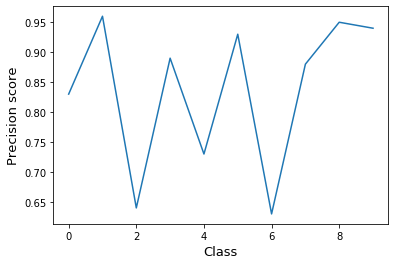

In [52]:
plt.plot(*zip(*precision))
plt.xlabel("Class",fontsize=13)
plt.ylabel("Precision score",fontsize=13)
plt.show()

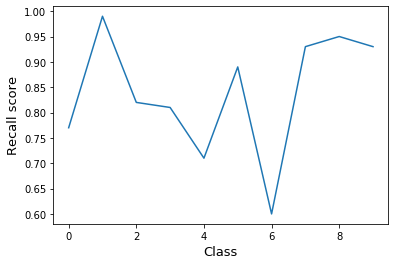

In [53]:
plt.plot(*zip(*recall))
plt.xlabel("Class",fontsize=13)
plt.ylabel("Recall score",fontsize=13)
plt.show()

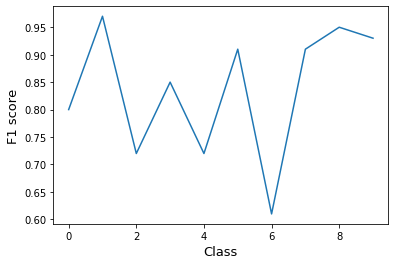

In [54]:
plt.plot(*zip(*f1))
plt.xlabel("Class",fontsize=13)
plt.ylabel("F1 score",fontsize=13)
plt.show()

<BarContainer object of 4 artists>

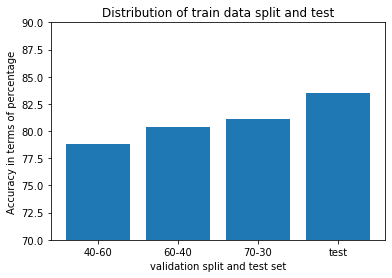

In [55]:
data = {'40-60': accuracy_40, '60-40': accuracy_60, '70-30': accuracy_70, 'test': accuracy}
names = list(data.keys())
values = list(data.values())
plt.title("Distribution of train data split and test")
plt.xlabel("validation split and test set")
plt.ylabel("Accuracy in terms of percentage")
plt.ylim(70,90)
plt.bar(names, values)

# Loading data for random forest

In [56]:
print(os.listdir("./data/train"))

with h5py.File('./data/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./data/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])


print("Shape of train data and train label:",data_train.shape,label_train.shape)

print(os.listdir("./Input"))
with h5py.File('./Input/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./Input/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])

print("Shape of test data and test label:",data_test.shape,label_test.shape)

['images_training.h5', 'labels_training.h5']
Shape of train data and train label: (30000, 784) (30000,)
['images_testing.h5', 'labels_testing_2000.h5']
Shape of test data and test label: (10000, 784) (2000,)


# Random Forest Classifier Functions

In [57]:
# Check purity function checks if the subset data provided as input
# contains single or multiple class
# True if single class, else False
def check_purity(data):
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

# This function is used to classify a data to its class
# once the data purity check is true
def classify_data(data):
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]

    return classification

# inputs are data and number of features to split on
# Returns a dictionary containing column index as key and
# Number of possible splits for each feature as values
def get_potential_splits(data, random_subspace):
    splits = {}
    n_columns = data.shape[1]
    col_ind = list(range(n_columns - 1))  
    if random_subspace and random_subspace <= len(col_ind):
        sample = np.arange(len(col_ind))
        np.random.shuffle(sample)
        col_ind = sample[:random_subspace]
    for column_index in col_ind:
        unique_values = np.unique(data[:, column_index])
        splits[column_index] = unique_values
    return splits


# Returns the entropy of data w.r.t label classes
def calculate_entropy(data):
    label_column = data[:, -1]
    counts = np.unique(label_column, return_counts=True)[1]
    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
    return entropy

# Overall entropy of data above and below the decision boundary
def calculate_overall_entropy(data_below, data_above):
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy = (p_data_below * calculate_entropy(data_below)
                       + p_data_above * calculate_entropy(data_above))

    return overall_entropy

# Used to specify the best split by iterating over entropy function
def determine_best_split(data, potential_splits):
    overall_entropy = 999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value

    return best_split_column, best_split_value


# Split the data and returns the data above and below the decision boundary
def split_data(data, split_column, split_value):
    split_column_values = data[:, split_column]

    data_below = data[split_column_values <= split_value]
    data_above = data[split_column_values > split_value]

    return data_below, data_above

# The main decision tree function which calls the best split function
# Creates questions and threshold for each split
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5, random_subspace=None):
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df

    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)

        return classification
    else:
        counter += 1
        potential_splits = get_potential_splits(data, random_subspace)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)

        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification
        feature_name = COLUMN_HEADERS[split_column]

        question = "{} <= {}".format(feature_name, split_value)
        sub_tree = {question: []}
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth, random_subspace)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth, random_subspace)

        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)

        return sub_tree

# Predict class of a sample by going through each split question of the tree
def predict_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    if example[int(feature_name)] <= float(value):
        answer = tree[question][0]
    else:
        answer = tree[question][1]
    if not isinstance(answer, dict):
        return answer
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

# Predict the test data of decision tree
def decision_tree_predictions(test_df, tree):
    predictions = test_df.apply(predict_example, args=(tree,), axis=1)
    return predictions

# Bootstraping data by given number of size 
def bootstrapping(train_df, n_bootstrap):
    bootstrap_indices = np.random.randint(low=0, high=len(train_df), size=n_bootstrap)
    df_bootstrapped = train_df.iloc[bootstrap_indices]

    return df_bootstrapped

# Main random forest function which includes bootstrapping
# Forming different decision tree and return them in a list
def random_forest_algorithm(data_train,label_train, n_trees, n_bootstrap, n_features, dt_max_depth):
    train_df = pd.DataFrame(data_train).join(pd.DataFrame(label_train).rename(columns = {0:'label'}))
    forest = []
    for i in range(n_trees):
        df_bootstrapped = bootstrapping(train_df, n_bootstrap)
        tree = decision_tree_algorithm(df_bootstrapped, max_depth=dt_max_depth, random_subspace=n_features)
        forest.append(tree)

    return forest

# To predict the test data using random forest model
def random_forest_predictions(data_test,label_test, forest):
    test_df = pd.DataFrame(data_test).join(pd.DataFrame(label_test).rename(columns = {0:'label'}))
    df_predictions = {}
    for i in range(len(forest)):
        column_name = "tree_{}".format(i)
        predictions = decision_tree_predictions(test_df, tree=forest[i])
        df_predictions[column_name] = predictions

    df_predictions = pd.DataFrame(df_predictions)
    random_forest_predictions = df_predictions.mode(axis=1)[0]

    return random_forest_predictions

# Returns Accuracy of model in percentage
def calculate_accuracy(predictions, labels):
    predictions_correct = predictions == labels
    accuracy = (predictions_correct.mean() * 100)

    return accuracy

# Calling Random Forest Classifier

In [58]:
start = time.time()
# Number of features
n_cols = int(data_train.shape[1]**0.5) # given as square root of total independent features
# hyper-parameters are updated in random_forest_algorithm function
forest = random_forest_algorithm(data_train,label_train, n_trees=33,n_bootstrap=800, n_features=n_cols, dt_max_depth=10)
end = time.time()

# Prediction and accuracy
y_pre = random_forest_predictions(data_test,label_test, forest)
accuracy = calculate_accuracy(y_pre[:2000],label_test)

print("Accuracy: {}%".format(accuracy))
print("Run Time:",round((end - start)/60.0,2),"Minutes")

Accuracy: 81.0%
Run Time: 9.66 Minutes


# kNN functions

In [61]:
#implementing kNN (only used to predict the first 150 labels using 1000 samples from the dataset due to time complexity)

#distance metric
def euclideanDistance(instance1, instance2, length):
    distance = 0
    for x in range(length): #going over all the features(pixels)
        distance += np.square(instance1[x] - instance2[x]) #euclidean distance
    return np.sqrt(distance)
 
#output the first k neighbours    
def getNeighbors(trainingSet, testInstance, k):
    distances = []
    #length = len(testInstance)-1 
    for x in range(1000):
        dist = euclideanDistance(testInstance, trainingSet[x], 784)
        distances.append((trainingSet[x], dist)) #appending tuples where first element is an image vector and the second is the distance
    distances.sort(key=operator.itemgetter(1)) #sorting the distances in ascending order
    neighbors = []
    for x in range(k): #nearest k neighbours
        neighbors.append(distances[x][0])
    return neighbors
 
#predicting the response, given the neighbours
def getResponse(neighbors):
    classVotes = {}
    for x in range(len(neighbors)):
        response = neighbors[x][-1]
        if response in classVotes:
            classVotes[response] += 1
        else:
            classVotes[response] = 1
    sortedVotes = sorted(classVotes.items(), key=operator.itemgetter(1), reverse=True)
    return sortedVotes[0][0]
 
#calculating the accuracy
def getAccuracy(testSet, predictions):
    count = testSet == predictions #correct classifications
    accuracy = count.sum()/len(count)
    return accuracy*100.0

# Calling kNN

In [62]:

    trainingSet = np.append(data_train_before_reshape,label_train[:,np.newaxis],axis=1)
    # generate predictions
    predictions=[]
    k = 3
    start_time = time.time()
    for x in range(200):
        neighbors = getNeighbors(trainingSet, data_test[x], k)
        result = getResponse(neighbors)
        predictions.append(result)
    accuracy = getAccuracy(label_test[:150], predictions[:150])
    elapsed_time = time.time()-start_time
    print("Accuracy: {}%".format(accuracy))
    print("Run Time:",round(elapsed_time/60.0,2),"Minutes")

Accuracy: 75.33333333333333%
Run Time: 6.7 Minutes


### How to output the prediction
Output a file “predicted_labels.h5” that can be loaded in the same way as above. You may use the following code to generate an output file that meets the requirement:

In [21]:
import numpy as np
# assume output is the predicted labels
with h5py.File('./Output/predicted_labels.h5','w') as H:
    H.create_dataset('output',data=y_pre)

We will load the output file using the code for loading data above. It is your responsibility to make sure the output file can be correctly loaded using this code.
The performance of your classifier will be evaluated in terms of the top-1 accuracy metric, i.e.<br /><br />
<div style="text-align: center"> $$\text{Accuracy} = \frac{\text{Number of correct classifications}}{\text{Total number of test examples used}} * 100\%$$

## Task description
Each group consists of 3 students. Your task is to determine / build a classifier for the given data set to classify images into categories and write a report. The score allocation is as follows:
    * Classifier (code): max 20 points
    * Report: max 80 points
Please refer to the rubric in Canvas for detailed marking scheme. The report and the code are to be submitted in Canvas by the due date.<br />
This assignment must be submitted in Python3. Although you are allowed to use external libraries for optimisation and linear algebraic calculations, you are NOT allowed to use external libraries for basic pre-processing or classification. For instance, you are allowed to use scipy.optimize for gradient descent or scipy.linalg.svd for matrix decomposition. However, you are NOT allowed to use sklearn.svm for classification (i.e. you have to implement the classifier yourself). If you have any ambiguity whether you can use a particular library or a function, please refer to Canvas -> Modules -> ”Assignment 1 FAQs” for clarification.

## Instructions to hand in the assignment
### Go to Canvas -> Assignments -> "Assignment 1" and submit 2 files only: the report and the code file.
1) Report (a .pdf file): The report should include each member’s details (student IDs and names)<br />
2) Code (a .ipynb file): The code must be able to be run with the following folder structure:
    - Algorithm (the root folder): Your .ipynb file containing Python code will be placed on this folder when we test and run your code. 
    - Input (a sub-folder under Algorithm): We will copy the test dataset into this Input folder when we test and run your code. Please make sure your code is able to read the test dataset from this Input folder.
    - Output (a sub-folder under Algorithm): Your code must be able to generate a prediction file named “predicted_labels.h5” to be saved in this Output folder. The prediction file should contain predicted labels of the test dataset. We will use your prediction output file for grading purpose.

Since this is a group work, only one student from your group needs to submit all the files which must be named with student ID numbers of all your group members separated by underscores e.g. “SID1xxxx_SID2xxxx_SID3xxxx.pdf”,  “SID1xxxx_SID2xxxx_SID3xxxx.ipynb”.

### Your submission should include the report and the code. 
A plagiarism checker will be used. Clearly provide instructions on how to run your code in the Appendix section of your report.

### The report must clearly show :
    1. Details of your classifier 
    2. The predicted results from your classifier on test examples
    3. Run-time
    4. Hardware and software specifications of the computer that you used for performance evaluation

### A template for writing the report 
Note that you have to strictly follow the format of the template. The maximum length of the report is 20 (including references).

### A penalty of MINUS 20 percent (-20%) for each day after the due date. 
The maximum delay for assignment submission is 5 (five) days, after which assignment will not be accepted.

**You should upload your assignment at least half a day or one day prior to the submission deadline to avoid network congestion**.

Canvas may not be able to handle a large number of submission happening at the same time. If you submit your assignment at a time close to the deadline, a submission error may occur causing your submission to be considered late. Penalty will be applied to late submission regardless of issues. 

### All files required for assignment 1 can be downloaded from Canvas -> Assignments -> Assignment 1
